In [32]:
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

import matplotlib.pyplot as plt
import json

#  13/2/2023: Oscillatory triangles

This week we will be looking at top hat and triangular forcing in more depth. 

We want to get a feel for the the non-instantaneous response of the deep sea. The lag, not in signal transmission, but in response. We want to develop a better feeling for this. We can also then compare with analytical functions...

So plan:
1.   positive followed by negative triangular forcing, compare with meeting notes
1.   top hat forcing of widths 5,50,200 years (compare different widths to fast vs recalcintrant time components)
1.   triangular forcing of widths 5,50,200 years
1.   look at analytical solution to step, extend to top hat? (TODO)
1.   oscillatory tophat forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
1.   link analytical expression to what we see (TODO)
1.   look at analytical solution triangular.(TODO)
1.   oscillatory triangular forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
1.   link analytical expression to what we see (TODO)
1.   Rerun everything with varying parameters. See effect on lag.
1.   Negative Heat capacity
1.   Top hat to constant>1 --> Smooth transition


### 1)Positive followed by negative triangular forcing, compare with meeting notes
For this we will have a wavelength of 200 years. Amplitude of 4xCO2 See signal below.

In [93]:
runs = {}

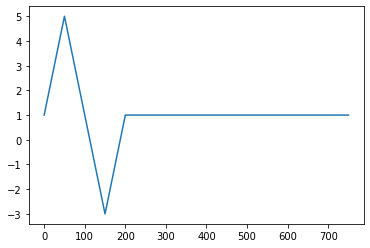

In [29]:
xs = np.arange(751) 
xs = xs * 4/50

xs[50:151] = xs[50:151]* -1

xs[50:151] = xs[50:151] + 8 
xs[151:201] = xs[151:201] - 16
xs += 1
xs[200:] = 1

triang_pulse = xs
plt.plot(xs)

In [94]:
#need to run cell above
steps = [triang_pulse]
step_names = ["Triangular Pulse"]

for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out


currently on Triangular Pulse... 


100%|██████████| 1000/1000 [00:16<00:00, 59.91it/s]


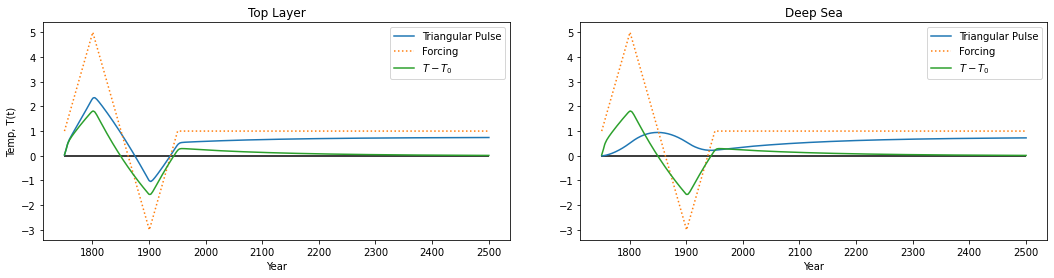

In [96]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

I think this illustrates what is going on pretty well. The top layer follows the forcing signal pretty closely, whereas the bottom layer displays a lag and rounds out the triangular signal. Instead of directly following the forcing, the deep-sea layer responds to the temperature difference $T-T_0$. The zero in $T-T_0$ seems to match the max deep sea temperature well. 
When $T-T_0$ approaches zero, the deep sea layer approaches equlibrium. It displays asymptotic behaviour because the top (buffer) layer also asymptotically(? yes?) approaches equilibrium.

Thinking about asymmetry, the deep sea response does appear to be quite symmetric. At least, no obvious asymmetry is visible. This is in agreement with Bouttes.

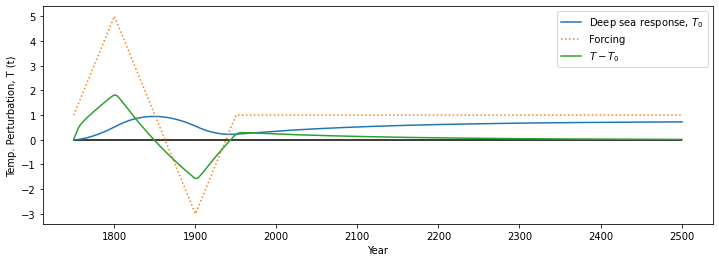

In [95]:
#For Report
fig, subpl = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(12)
#axs.set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (layer) in zip(layers):
        subpl.plot(run.time, run.tlev[:,1], label = "Deep sea response, $T_0$")
        #subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.set_ylabel('Temp. Perturbation, T (t)')
        subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        subpl.hlines(0, 1750, 2500, 'k')
        subpl.legend()

### 2)   Top hat forcing of widths: 5,50,200 years 
-compare different widths to fast vs recalcintrant time components

We will have the top hats set in after 50 years

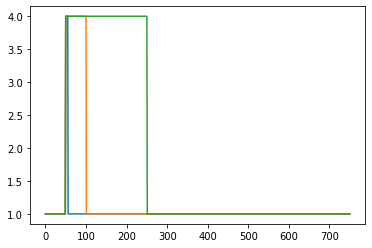

In [85]:
#Making top hat signals.

widths = [5,50,200]
tophat_signals = {}
for w in widths:
    sig = np.ones(751)
    sig[50:51+w] = 4
    tophat_signals[w] = sig
    plt.plot(sig)



In [100]:

for sig in tophat_signals:
    print(f"currently on tophat of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= tophat_signals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )

        out = scm.run()
    
    runs[f"TopHat Pulse width %s" %sig] = out




currently on tophat of width: 5... 


100%|██████████| 1000/1000 [00:15<00:00, 63.92it/s]


currently on tophat of width: 50... 


100%|██████████| 1000/1000 [00:15<00:00, 64.59it/s]


currently on tophat of width: 200... 


100%|██████████| 1000/1000 [00:15<00:00, 65.88it/s]


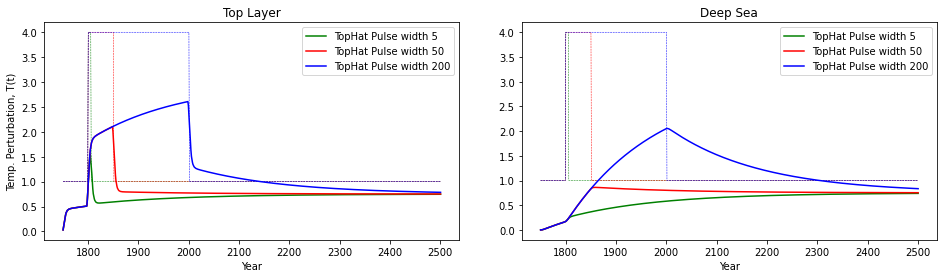

In [127]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

scenario_names = []
for w in widths: 
    scenario_names.append(f"TopHat Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, tophat_signals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, tophat_signals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
    
    
for subpl in axs:
     
    subpl.legend()

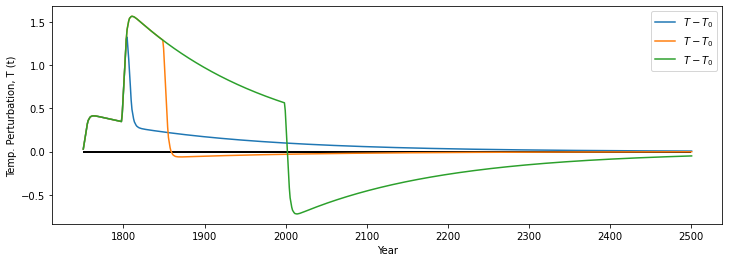

In [108]:
fig, subpl = plt.subplots(1)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(12)

scenario_names = []
for w in widths: 
    scenario_names.append(f"TopHat Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Deep Sea"]

for (run, scen, sig) in zip (run_outputs, scenario_names, tophat_signals):
    for (layer) in zip(layers):
        #subpl.plot(run.time, run.tlev[:,1], label = "Deep sea response, $T_0$")
        #subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.set_ylabel('Temp. Perturbation, T (t)')
        #subpl.plot(run.time,tophat_signals.get(sig)-1, linestyle = "dotted", label="Forcing")
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        subpl.hlines(0, 1750, 2500, 'k')
        subpl.legend()

There isn't really a time lag visible in $T_0$ response. This makes sense, the top layer temp drops off almost instantaneously, so the temp difference and corresponding heat flux is large. What's maybe more interesting, is that $T-T_0$, and thus the heat flux are negative for the widths 50 and 200. The lower layer, being slower to respond, has a higher temperature when the top layer temp suddenly drops, causing heat to be transferred out of the deep layer to the top layer. This accelerates the cooling of the bottom layer for the widest top hat, and slows the cooling of the top layer, see the top and bottom figures above.

==> This has to do with the 2 time component responses. 5 year pulse is too short for deep-sea (recalcitrant) response to affect top layer temp.

### 3) Triangular forcing of widths 5,50,200 years

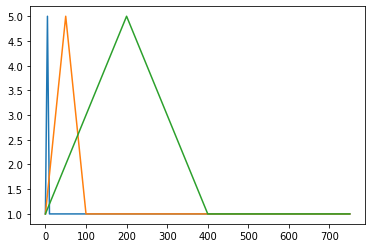

In [130]:
#Making triangular pulse hat signals.

widths = [5,50,200]
triang_signals = {}
for w in widths:

    xs = np.arange(751) 
    xs = xs * 4/w

    xs[w:(3*w+1)] = xs[w:(3*w+1)]* -1

    xs[w:(3*w+1)] = xs[w:(3*w+1)] + 8 
    xs[(3*w+1):(4*w+1)] = xs[(3*w+1):(4*w+1)] - 16
    xs += 1
    xs[2*w:] = 1 #This is the line to change if we also want negative triangular forcing

    triang_signals[w] = xs
    plt.plot(xs)

In [131]:
for sig in triang_signals:
    print(f"currently on triangle of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= triang_signals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )

        out = scm.run()
    
    runs[f"Triangular Pulse width %s" %sig] = out



currently on triangle of width: 5... 


100%|██████████| 1000/1000 [00:20<00:00, 49.36it/s]


currently on triangle of width: 50... 


100%|██████████| 1000/1000 [00:18<00:00, 53.71it/s]


currently on triangle of width: 200... 


100%|██████████| 1000/1000 [00:18<00:00, 53.49it/s]


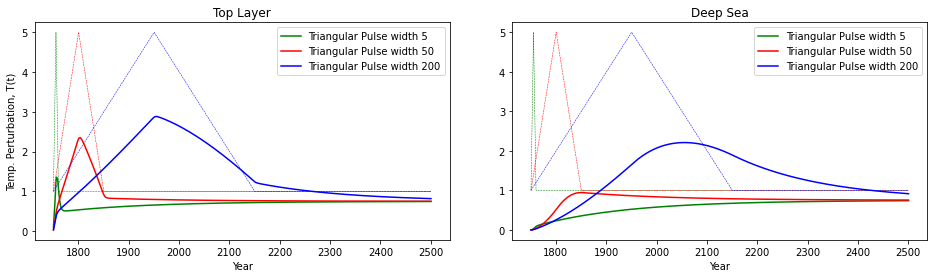

In [139]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

scenario_names = []
for w in widths: 
    scenario_names.append(f"Triangular Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, triang_signals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, triang_signals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend()

We can see how the 5-year pulse is too quick for the deep-sea to respond. 
I do definitely find it more illustrative to look at the temperature difference. 

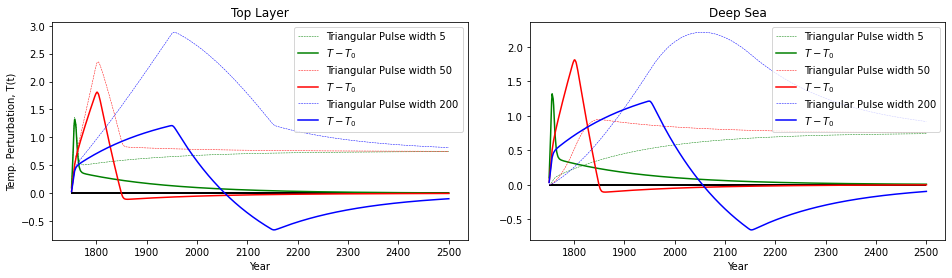

In [141]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

scenario_names = []
for w in widths: 
    scenario_names.append(f"Triangular Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, triang_signals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, linestyle = "dashed", color = color, linewidth=0.5)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, linestyle = "dashed", color = color, linewidth=0.5)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time, triang_signals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$",color = color)
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

### 5) Oscillatory tophat forcing 
of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )

This means a wavelength of 10,100, 400 years.
We will try with np.sgn.


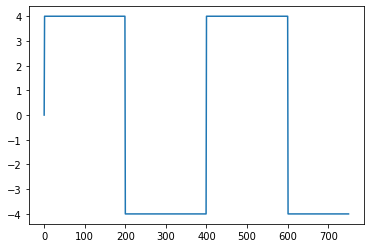

In [186]:
#Making oscillatory top hat signals.

widths = [5,50,200]
th_persignals = {}
for w in widths:

    xs = np.arange(751) 
    xs = 4*np.sign(np.sin(2*np.pi/(2*w) * xs))

    th_persignals[w] = xs
    #plt.plot(xs)
plt.plot(th_persignals[200])

In [171]:
for sig in th_persignals:
    print(f"currently on periodic tophat of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= th_persignals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=1
        )

        out = scm.run()
    runs[f"Periodic tophat width %s" %sig] = out
    

currently on periodic tophat of width: 5... 


100%|██████████| 1000/1000 [00:44<00:00, 22.24it/s]


currently on periodic tophat of width: 50... 


100%|██████████| 1000/1000 [00:44<00:00, 22.38it/s]


currently on periodic tophat of width: 200... 


100%|██████████| 1000/1000 [00:44<00:00, 22.31it/s]


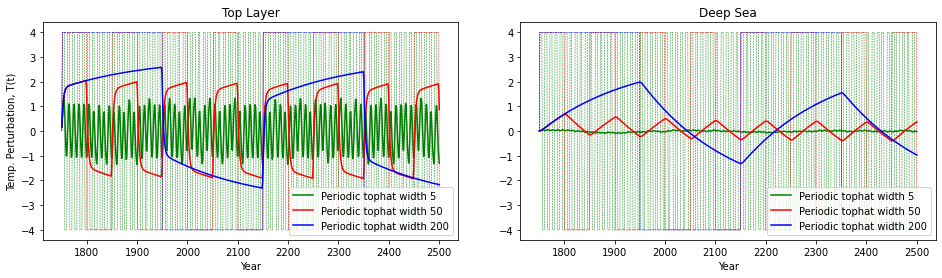

In [176]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [5,50,200]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic tophat width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, th_persignals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

First thoughts:
1. periodic forcing of width 200 deep sea : It looks asymmetric. But that is not what is meant by asymmetric forcing. EXPLAIN .. maybe triangular forcing will clarify.  TODO

1. Why does the deep sea width 50 forcing drift downwards? 

1. Can we explain the strange deep sea behaviour for width 5? => Due to random (due to sine use in defining top hat signals) variations in top layer temp.

1.  Why is the the shortest width 5 top layer behaving so strangely, oscillating in such a strange manner. => It had to do with the time step


Let's address question 4 first.
Time to replot..

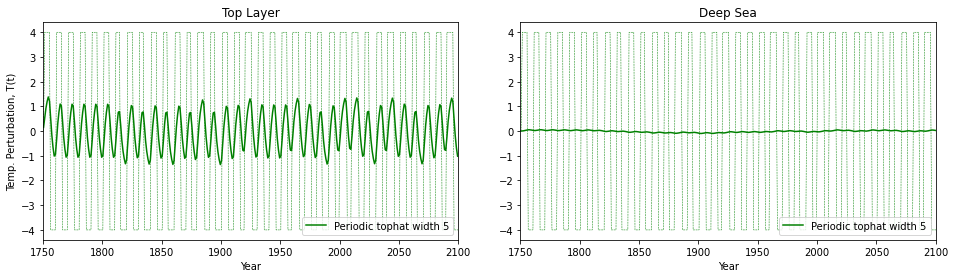

In [175]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [5]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic tophat width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, th_persignals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        subpl.set_xlim(1750,2100)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

~~It almost appears stochastic in nature..~~

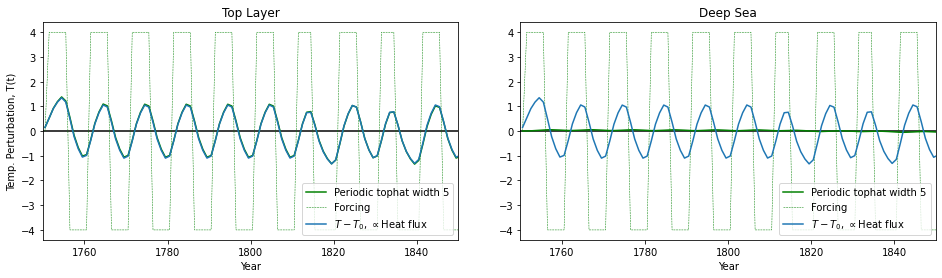

In [185]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [5]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic tophat width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, widths):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5, label = "Forcing")
        subpl.set_xlim(1750,1850)
        subpl.hlines(0,1750,2500)
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$, $\propto$Heat flux")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

~~We can see from the first top hat that the top layer temp increases immediately, reaches equilibrium, and then starts to decrease. It decreases because the heat flux to the deep sea layer starts to occur? Or is this because of the net feedback parameter term, $\lambda T$ ? Why does the zero occur at the same time the top hat flips?~~

The time step dt was too short. I decreased it from 3 to 1. The variation in perturbation heights now seems to come from variation in forcing widths.. Think this happend because of how i created the forcing signals using sines. Rounding errors. 


50


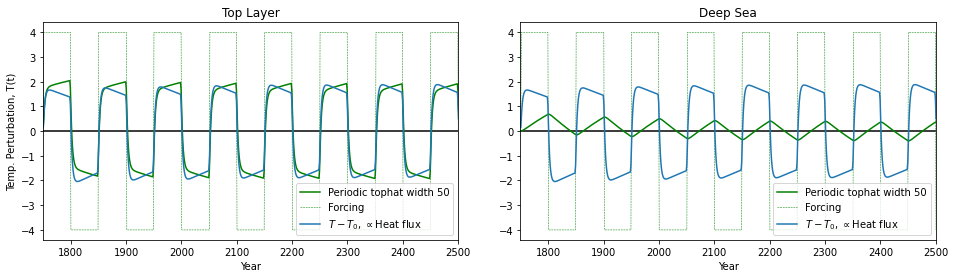

In [184]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [50]
scenario_names = []

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic tophat width %s" %w)

run_outputs = []
run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, widths):
    print (sig)
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5, label = "Forcing")
        subpl.set_xlim(1750,2500)
        subpl.hlines(0,1750,2500)
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$, $\propto$Heat flux")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

### 8) Oscillatory triangular forcing 

of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )

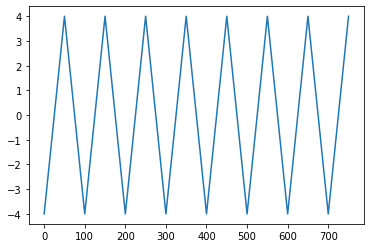

In [209]:
#Making oscillatory top hat signals.
from scipy import signal


#plt.plot(xs, 4*signal.sawtooth(xs, width = 0.5))

widths = [5,50,200]
tri_persignals = {}
for w in widths:

    xs = np.arange(751) 
    xs = 4*signal.sawtooth(2*np.pi/(2*w) * xs, width = 0.5)
    tri_persignals[w] = xs
    
plt.plot(tri_persignals[50])

In [210]:
for sig in tri_persignals:
    print(f"currently on periodic triangle of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= tri_persignals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=2
        )

        out = scm.run()
    runs[f"Periodic triangle width %s" %sig] = out
    

currently on periodic triangle of width: 5... 


100%|██████████| 1000/1000 [00:30<00:00, 32.45it/s]


currently on periodic triangle of width: 50... 


100%|██████████| 1000/1000 [00:23<00:00, 42.52it/s]


currently on periodic triangle of width: 200... 


100%|██████████| 1000/1000 [00:22<00:00, 43.51it/s]


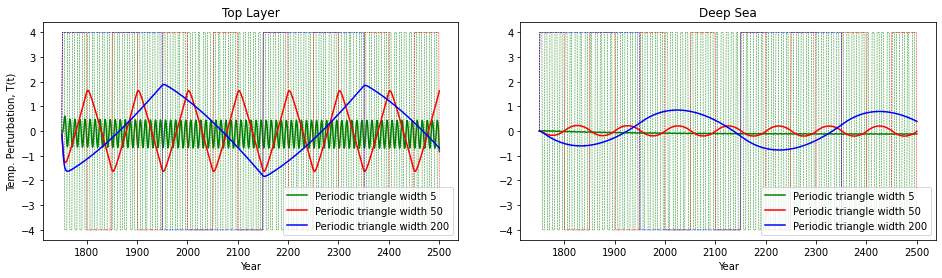

In [211]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [5,50,200]

scenario_names = []
for w in widths: 
    scenario_names.append(f"Periodic triangle width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, th_persignals):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, th_persignals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend(loc="lower right")

First thoughts:
1. Triangle of width 50 looks quite symmetric. 

## 11) Negative Heat Capacity

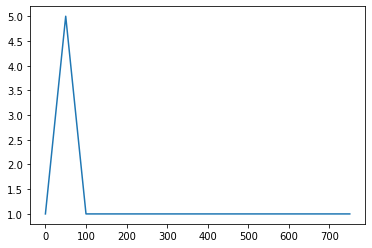

In [216]:
#Making triangular pulse hat signals.

widths = [5,50,200]
widths = [50]
triang_signals = {}
for w in widths:

    xs = np.arange(751) 
    xs = xs * 4/w

    xs[w:(3*w+1)] = xs[w:(3*w+1)]* -1

    xs[w:(3*w+1)] = xs[w:(3*w+1)] + 8 
    xs[(3*w+1):(4*w+1)] = xs[(3*w+1):(4*w+1)] - 16
    xs += 1
    xs[2*w:] = 1 #This is the line to change if we also want negative triangular forcing

    triang_signals[w] = xs
    plt.plot(xs)

In [217]:
for sig in triang_signals:
    print(f"currently on triangle of width: %s... "%sig)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= triang_signals[sig],
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=-75,
            gamma_2l=0.7,
            outtime=np.arange(1750.5,2501),
            dt=3
        )

        out = scm.run()
    
    runs[f"Triangular Pulse width %s" %sig] = out



currently on triangle of width: 50... 


100%|██████████| 1000/1000 [00:16<00:00, 59.79it/s]


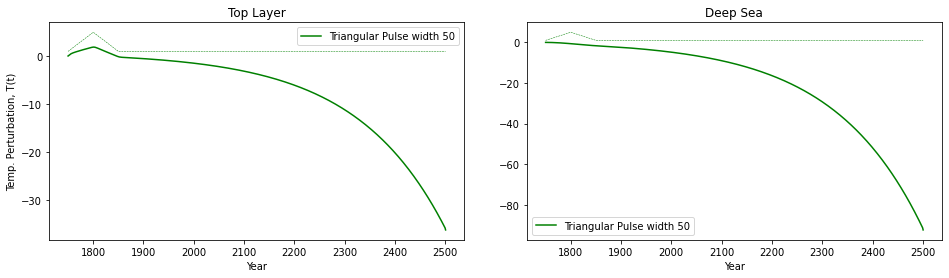

In [218]:

fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(16)
axs[0].set_ylabel('Temp. Perturbation, T(t)');

widths = [50]
scenario_names = []
for w in widths: 
    scenario_names.append(f"Triangular Pulse width %s" %w)

run_outputs = [runs.get(key) for key in scenario_names]

layers = ["Top Layer", "Deep Sea"]
colors = ["g", "r", "b"]

for (run, scen, color, sig) in zip (run_outputs, scenario_names, colors, widths):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen, color = color)
        else:
            subpl.plot(run.time, run.tlev[:,1], label = scen, color = color)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time, triang_signals.get(sig), linestyle = "dashed", color = color, linewidth=0.5)
        #subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        
    
    
for subpl in axs:
     
    subpl.legend()